In [1]:
from PIL import Image
from scipy import ndimage

import matplotlib.pyplot as plt
import numpy as np
import os
import json
import cv2

# Project 3a

In [2]:
def read_image(path):
    img = Image.open(path)
    out = np.asarray(img, dtype=np.float64)
    out = out / out.max()
    return out

## Part 1: Shoot the Pictures

In [3]:
set1 = "../../img/pano_3"
set2 = "../../img/pano_4"

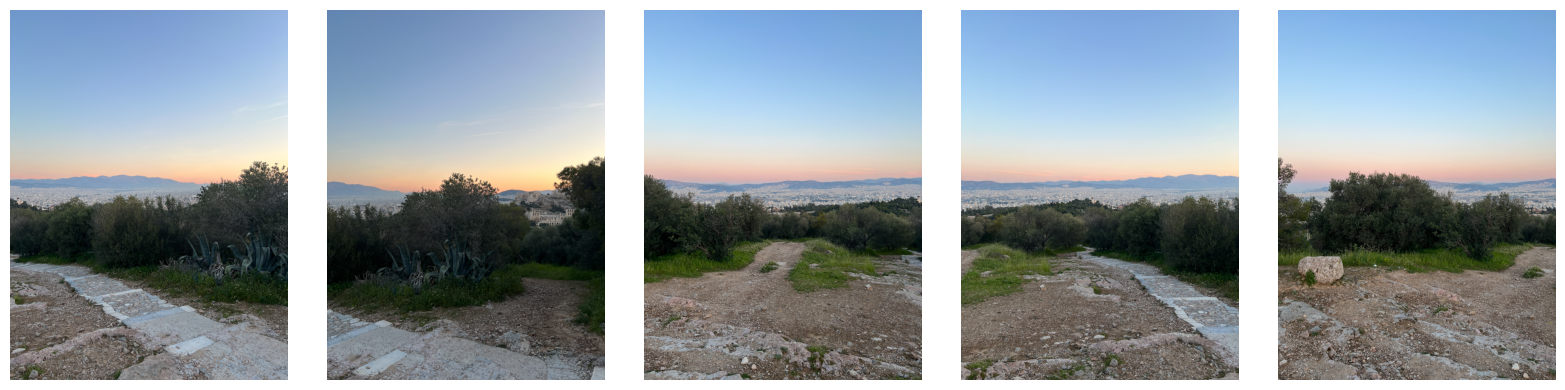

In [4]:
fig, axes = plt.subplots(1, 5, figsize=(16, 4))

for i, f in enumerate(os.listdir(set1)):
    axes[i].imshow(read_image(os.path.join(set1, f)))
    axes[i].axis("off")

plt.tight_layout()
plt.show()

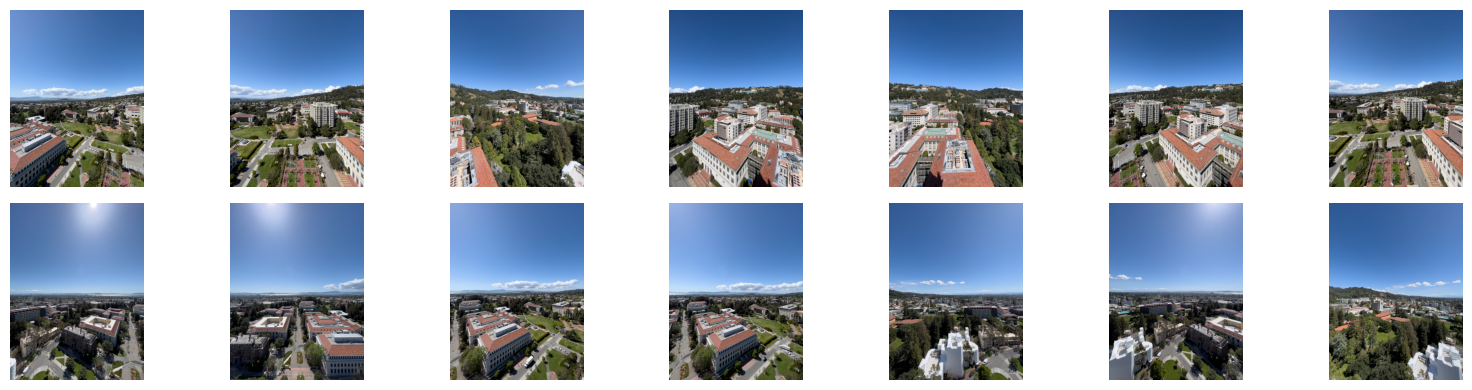

In [5]:
fig, axes = plt.subplots(2, 7, figsize=(16, 4))

for i, f in enumerate(os.listdir(set2)):
    axes[i // 7][i % 7].imshow(read_image(os.path.join(set2, f)))
    axes[i // 7][i % 7].axis("off")

plt.tight_layout()
plt.show()

## Part 2: Recover Homographies

In [6]:
def computeH(p1, p2):
    im1_pts = np.asarray(p1, dtype=np.float64)
    im2_pts = np.asarray(p2, dtype=np.float64)
    N = im1_pts.shape[0]

    # Aw = b
    A = np.zeros((2 * N, 8), dtype=np.float64)
    b = np.zeros((2 * N,), dtype=np.float64)

    for i, ((x, y), (xp, yp)) in enumerate(zip(im1_pts, im2_pts)):
        # xp = h11*x + h12*y + h13 - h31*x*xp - h32*y*xp - 1*xp
        # yp = h21*x + h22*y + h23 - h31*x*yp - h32*y*yp - 1*yp
        
        A[2*i, 0:3] = [x, y, 1]
        A[2*i, 6:8] = [-x * xp, -y * xp]
        b[2*i] = xp

        A[2*i+1, 3:6] = [x, y, 1]
        A[2*i+1, 6:8] = [-x * yp, -y * yp]
        b[2*i+1] = yp

    w, *_ = np.linalg.lstsq(A, b)
    H = np.reshape(np.append(w, 1), (3, 3))

    return H

In [7]:
correspondence = json.load(open("correspondences/2_3.json", "r"))
im1_pts = np.array(correspondence["im1Points"])[:, ::-1]
im2_pts = np.array(correspondence["im2Points"])[:, ::-1]

H = computeH(im1_pts, im2_pts)
print(H)

[[ 1.23908710e+00  3.70198604e-01 -1.45917469e+02]
 [-1.51962921e-01  1.49890322e+00 -5.10552730e+02]
 [-1.56443141e-04  7.58403119e-04  1.00000000e+00]]


## Part 3: Warp the Images

In [8]:
def interpolate(method, img, pts):
    x, y = pts.transpose(-1, *range(pts.ndim - 1))
    h, w = img.shape[:2]
    C = 1 if img.ndim == 2 else img.shape[2]
    
    if method in (0, "nn"):
        xr, yr = np.rint(x).astype(int), np.rint(y).astype(int)

        mask = (xr >= 0) & (xr < h) & (yr >= 0) & (yr < w)
        
        out = np.zeros((x.size, C), dtype=float)
        out[mask] = (img if C > 1 else img[..., None])[xr[mask], yr[mask]]
        
        return out
        # return img[xr, yr]
        
    elif method in (1, "bil"):
        # x_floor, x_ceil, y_floor, y_ceil
        xf, yf = np.floor(x).astype(int), np.floor(y).astype(int)
        xc, yc = xf + 1, yf + 1

        mask = (xf >= 0) & (xc < h) & (yf >= 0) & (yc < w)
        
        t, r, b, l = x-xf, yc-y, xc-x, y-yf # top, right, bottom, left distances
        tr, tl, bl, br = l*b, b*r, r*t, t*l # top right, top left, bottom left, bottom right weights

        out = np.zeros((x.size, C), dtype=float)
        out[mask] = (
            img[xf[mask], yf[mask]] * tl[mask][..., None] +
            img[xf[mask], yc[mask]] * tr[mask][..., None] +
            img[xc[mask], yf[mask]] * bl[mask][..., None] + 
            img[xc[mask], yc[mask]] * br[mask][..., None]
        )

        return out
        # return (img[xf, yf] * tl[..., None] + img[xf, yc] * tr[..., None] + img[xc, yf] * bl[..., None] + img[xc, yc] * br[..., None])

def warp(method, img, H):
    h, w = img.shape[:2]
    C = 1 if img.ndim == 2 else img.shape[2]
    
    corners = np.array([[0, 0, h, h],
                        [0, w, w, 0],
                        [1, 1, 1, 1]], dtype=float)
    warped = H @ corners
    warped = (warped[:2] / warped[2]).T

    xy_min, xy_max = np.min(warped, axis=0), np.max(warped, axis=0)

    # make output grid
    offset = np.floor(xy_min).astype(int)
    out_hw = (np.floor(xy_max).astype(int) - offset + 1)
    out_h, out_w = int(out_hw[0]), int(out_hw[1])

    rr, cc = np.mgrid[0:out_h, 0:out_w]
    rr_abs, cc_abs = rr + offset[0], cc + offset[1]

    # inverse warping
    H_inv = np.linalg.inv(H)
    target = np.vstack([rr_abs.ravel(), cc_abs.ravel(), np.ones(rr_abs.size, dtype=float)])
    source = H_inv @ target
    source = (source[:2] / source[2]).T

    # interpolate
    out = np.zeros((out_h, out_w, C), dtype=float)
    interpolated = interpolate(method, img if C > 1 else img[..., None], source)
    out.reshape(-1, C)[:] = interpolated

    if img.ndim == 2:
        out = out[..., 0]

    return np.clip(out, 0, 1), offset

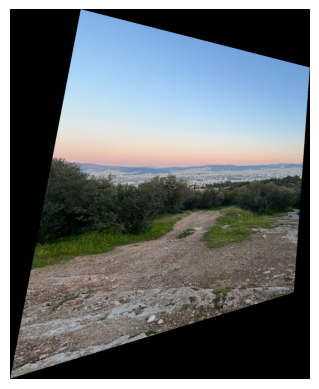

In [9]:
img = read_image("../../img/pano_3/2.jpg")
warped = warp(1, img, H)[0]

plt.axis("off")
plt.imshow(warped)
plt.show()

In [10]:
# rectification

img_stadium = read_image("../../img/stadium.jpg")
img_building = read_image("../../img/building.jpg")

# calculated in photoshop
coords_stadium = np.array([[109, 642], [136, 394], [510, 395], [505, 688]])
coords_building = np.array([[790, 291], [803, 232], [969, 230], [957, 291]])

target_stadium = np.array([[109, 693], [109, 394], [535, 394], [535, 693]])
target_building = np.array([[797, 291], [797, 231], [963, 231], [963, 291]])

H_stadium = computeH(coords_stadium, target_stadium)
H_building = computeH(coords_building, target_building)

In [11]:
def plot_cycle(ax, points: np.ndarray, **kwargs):
    cycled_points = np.vstack([points, points[:1]])
    ax.plot(*cycled_points.T, **kwargs)

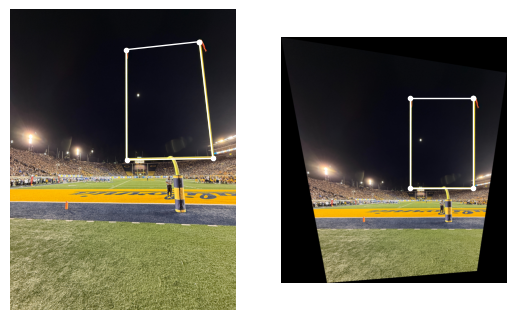

In [12]:
fig, axs = plt.subplots(1, 2)
axs[0].axis("off")
axs[0].imshow(img_stadium)
plot_cycle(axs[0], coords_stadium[:, ::-1], linewidth=1, marker='.', color='white')

rectified_im0, offset_im0 = warp(1, img_stadium, H_stadium)
axs[1].axis("off")
axs[1].imshow(rectified_im0)
plot_cycle(axs[1], (target_stadium - offset_im0)[:, ::-1], linewidth=1, marker='.', color='white')
plt.show()

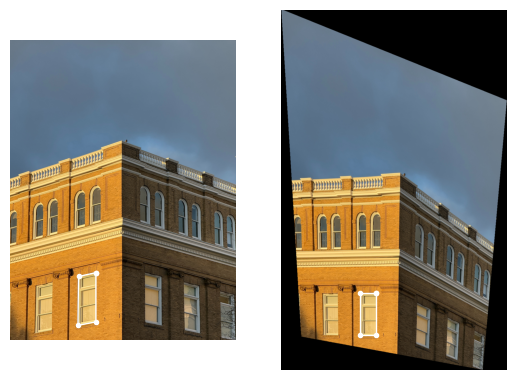

In [13]:
fig, axs = plt.subplots(1, 2)
axs[0].axis("off")
axs[0].imshow(img_building)
plot_cycle(axs[0], coords_building[:, ::-1], linewidth=1, marker='.', color='white')

rectified_im1, offset_im1 = warp(1, img_building, H_building)
axs[1].axis("off")
axs[1].imshow(rectified_im1)
plot_cycle(axs[1], (target_building - offset_im1)[:, ::-1], linewidth=1, marker='.', color='white')
plt.show()

## Part 4: Image Mosiac

In [14]:
def gaussian_stack(img, depth=4, sigma=1.6):
    img = np.asarray(img, dtype=np.float32)
    if img.ndim == 2:
        img = img[..., None]
    g = [img]
    for i in range(depth):
        g_blur = cv2.GaussianBlur(g[-1], (0, 0), sigmaX=sigma, borderType=cv2.BORDER_REFLECT_101)
        h, w = g_blur.shape[:2]
        small = cv2.resize(g_blur, (w // 2, h // 2), interpolation=cv2.INTER_AREA)
        if small.ndim == 2:
            small = small[..., None]
        g.append(small)
    return g

def laplacian_stack(img, depth=4, sigma=1.6):
    g, l = gaussian_stack(img, depth, sigma), []
    for i in range(depth):
        h, w = g[i].shape[:2]
        g_next = cv2.resize(g[i + 1], (w, h), interpolation=cv2.INTER_LINEAR)
        l.append(g[i] - g_next)
    l.append(g[-1])
    return l

def collapse_blend(l):
    out = l[-1]
    for i in range(len(l) - 2, -1, -1):
        h, w = l[i].shape[:2]
        l_next = cv2.resize(out, (w, h), interpolation=cv2.INTER_LINEAR)
        out = l_next + l[i]
    return out

In [15]:
def buffer_images(imgs, offsets):
    offsets = np.asarray(offsets, dtype=int)
    sizes = np.array([img.shape[:2] for img in imgs], dtype=int)
    mins, maxes = offsets, offsets + sizes

    tl = mins.min(axis=0)
    br = maxes.max(axis=0)
    h_out, w_out = (br - tl).tolist()

    C = imgs[0].shape[-1]
    out = np.zeros((len(imgs), h_out, w_out, C), dtype=np.float32)

    for i, img in enumerate(imgs):
        y0, x0 = (offsets[i] - tl).tolist()
        h, w = sizes[i].tolist()
        out[i, y0:y0+h, x0:x0+w, :] = img

    return out

def blending_weights(imgs):
    img = np.asarray(imgs, dtype=np.float32)
    dists = []

    # dist to border per img
    for img in imgs:
        valid = (img > 0).any(axis=2).astype(np.uint8)
        dists.append(ndimage.distance_transform_edt(valid).astype(np.float32))
    
    d = np.stack(dists, axis=0)+ 1e-12
    w = d / d.sum(axis=0, keepdims=True)
    
    return w[..., None]

def blend(imgs, depth=4, sigma=1.6):
    imgs = np.asarray(imgs, dtype=np.float32)
    N = imgs.shape[0]
    wp = [gaussian_stack(blending_weights(imgs)[i], depth, sigma) for i in range(N)] # weight pyramids
    lp = [laplacian_stack(imgs[i], depth, sigma) for i in range(N)] # laplacian pyramids

    # all levels
    blended_levels = []
    for level in range(depth):
        wl = np.stack([wp[i][level] for i in range(N)], axis=0) # weight at single level for imgs
        ll = np.stack([lp[i][level] for i in range(N)], axis=0) # laplacians at same level for imgs
        blended_levels.append(np.sum(wl * ll, axis=0)) # weights * laplacian

    # add back coarsest gaussian
    wl = np.stack([wp[i][-1] for i in range(N)], axis=0)
    gl = np.stack([lp[i][-1] for i in range(N)], axis=0)
    blended_levels.append(np.sum(wl * gl, axis=0))

    return np.clip(collapse_blend(blended_levels), 0, 1)

In [16]:
def mosiac(imgs, correspondence):
    pts = [np.array(correspondence[key])[:, ::-1] for key in ["im1Points", "im2Points"]]
    H = computeH(pts[0], pts[1])

    warped1, offset1 = warp(1, imgs[0], H)
    warped2, offset2 = warp(1, imgs[1], np.eye(3))

    buf = buffer_images([warped1, warped2], [offset1, offset2]).astype(np.float32)
    return blend(buf)

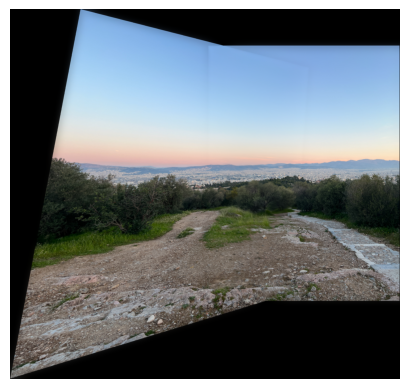

In [17]:
img1 = read_image("../../img/pano_3/2.jpg").astype(np.float32)
img2 = read_image("../../img/pano_3/3.jpg").astype(np.float32)
correspondence = json.load(open("correspondences/2_3.json", "r"))

result = mosiac([img1, img2], correspondence)
plt.axis("off"); plt.imshow(np.clip(result, 0, 1)); plt.show()

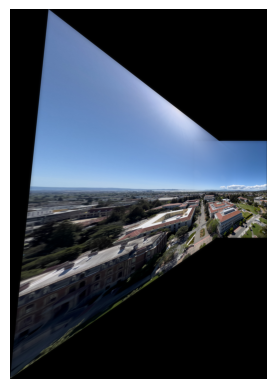

In [18]:
img1 = read_image("../../img/pano_4/5.jpg").astype(np.float32)
img2 = read_image("../../img/pano_4/6.jpg").astype(np.float32)
correspondence = json.load(open("correspondences/5_6.json", "r"))

result = mosiac([img1, img2], correspondence)
plt.axis("off"); plt.imshow(np.clip(result, 0, 1)); plt.show()

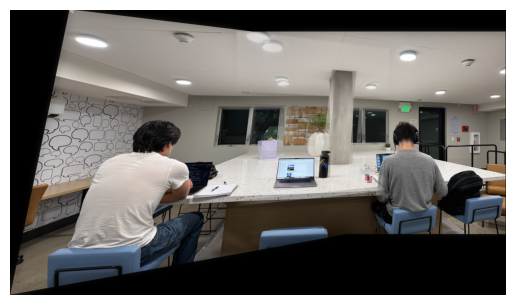

In [19]:
img1 = read_image("../../img/pano_5/1.jpg").astype(np.float32)
img2 = read_image("../../img/pano_5/2.jpg").astype(np.float32)
correspondence = json.load(open("correspondences/1_2.json", "r"))

result = mosiac([img1, img2], correspondence)
plt.axis("off"); plt.imshow(np.clip(result, 0, 1)); plt.show()